# Interpreting Network Solutions: Reading and Evaluating Recommendations

This notebook demonstrates how to **interpret network model solutions** - understanding what recommendations mean and whether they make sense.

Understanding solution interpretation is essential because:
- **Network models provide recommendations** - you must understand what they mean
- **Solutions specify flows and paths** - you need to parse this information correctly
- **Misinterpreting solutions** leads to implementation failures
- **Critical evaluation** prevents implementing bad recommendations


## Key Concepts

**Network Solutions Show**:
- **Flow amounts**: How much should flow through each link
- **Routing paths**: Which routes should be used
- **Both are essential** for implementation

**Interpreting Solutions Requires**:
- Understanding what flows and paths mean
- Checking if paths actually exist in the network
- Verifying if flows respect capacity constraints
- Evaluating if solutions make sense given objectives

**Common Misinterpretations**:
- Confusing total flow with flow on a specific path
- Assuming solutions are optimal without checking assumptions
- Not verifying that recommended paths exist
- Not checking if flows exceed capacity

**Critical insight**: Solutions are recommendations, not commands. You must interpret and evaluate them before implementing.


## Scenario: Logistics Routing Recommendation

A network model recommends routing delivery trucks through specific routes. You receive this solution and must evaluate it.

**The Solution**:
- Route 10 trucks from Warehouse A to Store 1
- Route 5 trucks from Warehouse A to Store 2
- Route 8 trucks from Warehouse B to Store 1

**The Challenge**:
- Does Warehouse A actually connect to Store 1?
- Can these routes handle the recommended number of trucks?
- Does the solution make sense given capacity constraints?
- Are there any problems with the recommendation?

**The Question**: How do you interpret this solution? What questions should you ask?


## Step 1: Install Required Packages (Colab)


In [1]:
%pip install networkx matplotlib pandas -q



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


## Step 2: Import Libraries


In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('default')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10


## Step 3: Set Up Network and Solution

Let's create a network and a model solution to interpret:


In [3]:
# Create network structure
G = nx.DiGraph()
G.add_nodes_from(['WA', 'WB', 'S1', 'S2'])

# Network links with capacities
network_links = [
    ('WA', 'S1', 15),  # Warehouse A to Store 1, capacity: 15 trucks
    ('WA', 'S2', 10),  # Warehouse A to Store 2, capacity: 10 trucks
    ('WB', 'S1', 12),  # Warehouse B to Store 1, capacity: 12 trucks
    ('WB', 'S2', 8)    # Warehouse B to Store 2, capacity: 8 trucks
]

for from_node, to_node, capacity in network_links:
    G.add_edge(from_node, to_node, capacity=capacity)

# Model solution (recommendations)
solution = [
    ('WA', 'S1', 10),  # Route 10 trucks from WA to S1
    ('WA', 'S2', 5),   # Route 5 trucks from WA to S2
    ('WB', 'S1', 8)    # Route 8 trucks from WB to S1
]

print("NETWORK STRUCTURE:")
print("=" * 60)
for from_node, to_node, capacity in network_links:
    print(f"{from_node} → {to_node}: Capacity = {capacity} trucks")

print("\nMODEL SOLUTION (Recommendations):")
print("=" * 60)
for from_node, to_node, flow in solution:
    print(f"Route {flow} trucks from {from_node} to {to_node}")

# Create solution DataFrame
solution_df = pd.DataFrame(solution, columns=['From', 'To', 'Recommended_Flow'])
print("\nSOLUTION SUMMARY:")
display(solution_df)


NETWORK STRUCTURE:
WA → S1: Capacity = 15 trucks
WA → S2: Capacity = 10 trucks
WB → S1: Capacity = 12 trucks
WB → S2: Capacity = 8 trucks

MODEL SOLUTION (Recommendations):
Route 10 trucks from WA to S1
Route 5 trucks from WA to S2
Route 8 trucks from WB to S1

SOLUTION SUMMARY:


,From,To,Recommended_Flow
0,WA,S1,10
1,WA,S2,5
2,WB,S1,8


## Step 4: Interpret the Solution - Check Paths Exist

First, verify that recommended paths actually exist in the network:


In [4]:
print("STEP 1: CHECK IF PATHS EXIST")
print("=" * 60)

path_validation = []
for from_node, to_node, flow in solution:
    path_exists = G.has_edge(from_node, to_node)
    path_validation.append({
        'Route': f"{from_node} → {to_node}",
        'Recommended_Flow': flow,
        'Path_Exists': '✓ Yes' if path_exists else '✗ No',
        'Valid': path_exists
    })

path_df = pd.DataFrame(path_validation)
display(path_df)

all_paths_valid = all([G.has_edge(f, t) for f, t, _ in solution])
if all_paths_valid:
    print("\n✓ All recommended paths exist in the network")
else:
    print("\n⚠️  WARNING: Some recommended paths do not exist!")
    print("   This solution cannot be implemented as recommended.")


STEP 1: CHECK IF PATHS EXIST


,Route,Recommended_Flow,Path_Exists,Valid
0,WA → S1,10,✓ Yes,True
1,WA → S2,5,✓ Yes,True
2,WB → S1,8,✓ Yes,True



✓ All recommended paths exist in the network


## Step 5: Interpret the Solution - Check Capacity Constraints

Next, verify that recommended flows respect capacity constraints:


In [5]:
print("STEP 2: CHECK CAPACITY CONSTRAINTS")
print("=" * 60)

capacity_validation = []
for from_node, to_node, flow in solution:
    if G.has_edge(from_node, to_node):
        capacity = float(G[from_node][to_node]['capacity'])  # Ensure numeric type
        within_capacity = flow <= capacity
        utilization = (flow / capacity * 100) if capacity > 0 else 0
        
        capacity_validation.append({
            'Route': f"{from_node} → {to_node}",
            'Recommended_Flow': flow,
            'Capacity': capacity,
            'Within_Capacity': '✓ Yes' if within_capacity else '✗ No - EXCEEDS!',
            'Utilization_%': f"{utilization:.1f}%",
            'Valid': within_capacity
        })
    else:
        capacity_validation.append({
            'Route': f"{from_node} → {to_node}",
            'Recommended_Flow': flow,
            'Capacity': 'N/A (path does not exist)',
            'Within_Capacity': 'N/A',
            'Utilization_%': 'N/A',
            'Valid': False
        })

capacity_df = pd.DataFrame(capacity_validation)
display(capacity_df)

all_within_capacity = all([row['Valid'] for row in capacity_validation])
if all_within_capacity:
    print("\n✓ All recommended flows are within capacity")
else:
    print("\n⚠️  WARNING: Some recommended flows exceed capacity!")
    print("   This solution cannot be implemented as recommended.")


STEP 2: CHECK CAPACITY CONSTRAINTS


,Route,Recommended_Flow,Capacity,Within_Capacity,Utilization_%,Valid
0,WA → S1,10,15.0,✓ Yes,66.7%,True
1,WA → S2,5,10.0,✓ Yes,50.0%,True
2,WB → S1,8,12.0,✓ Yes,66.7%,True



✓ All recommended flows are within capacity


## Step 6: Visualize Solution on Network

Visualizing the solution on the network helps you see what it recommends:


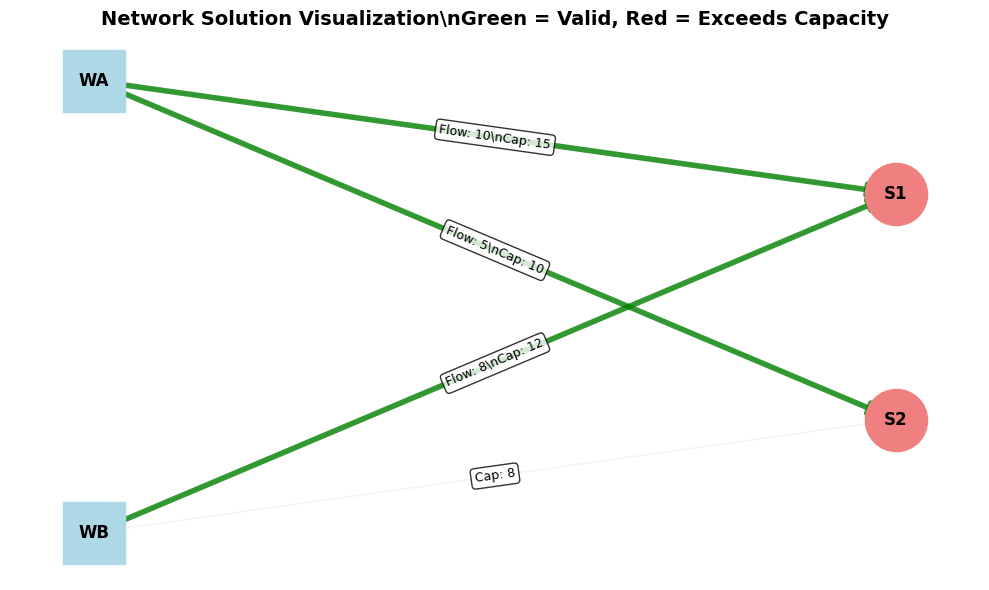

\nKey Observations:
  • Solution shows recommended flows on specific paths
  • Visual representation makes it easy to see if flows respect capacity
  • Red edges indicate problems (flow exceeds capacity)
  • Green edges indicate valid recommendations


In [6]:
# Create layout
pos = {
    'WA': (0, 1), 'WB': (0, 0),
    'S1': (2, 0.75), 'S2': (2, 0.25)
}

# Draw network with solution
fig, ax = plt.subplots(figsize=(10, 6))

# Draw nodes
nx.draw_networkx_nodes(G, pos, nodelist=['WA', 'WB'], 
                      node_color='lightblue', node_size=2000, node_shape='s')
nx.draw_networkx_nodes(G, pos, nodelist=['S1', 'S2'], 
                      node_color='lightcoral', node_size=2000, node_shape='o')

# Draw all edges (gray, thin)
nx.draw_networkx_edges(G, pos, edge_color='lightgray', width=1, 
                       arrows=True, arrowsize=15, alpha=0.3)

# Draw solution edges (colored, thick)
solution_edges = [(f, t) for f, t, _ in solution]
solution_flows = {f"{f}→{t}": flow for f, t, flow in solution}

for from_node, to_node, flow in solution:
    if G.has_edge(from_node, to_node):
        capacity = float(G[from_node][to_node]['capacity'])  # Ensure numeric type
        color = 'green' if flow <= capacity else 'red'
        width = 4 if flow <= capacity else 5
        nx.draw_networkx_edges(G, pos, edgelist=[(from_node, to_node)], 
                              edge_color=color, width=width, arrows=True, 
                              arrowsize=20, alpha=0.8)

# Add labels
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

# Add flow and capacity labels
edge_labels = {}
for from_node, to_node, capacity in network_links:
    # Check if this edge is in solution
    flow = next((fl for f, t, fl in solution if f == from_node and t == to_node), None)
    if flow is not None:
        label = f"Flow: {flow}\\nCap: {capacity}"
        if flow is not None and float(flow) > float(capacity):
            label += "\\n⚠️ EXCEEDS!"
    else:
        label = f"Cap: {capacity}"
    edge_labels[(from_node, to_node)] = label

nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=9, 
                              bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.title('Network Solution Visualization\\nGreen = Valid, Red = Exceeds Capacity', 
         fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

print("\\nKey Observations:")
print("  • Solution shows recommended flows on specific paths")
print("  • Visual representation makes it easy to see if flows respect capacity")
print("  • Red edges indicate problems (flow exceeds capacity)")
print("  • Green edges indicate valid recommendations")


In [7]:
print("COMMON MISINTERPRETATION: Flow Amounts")
print("=" * 60)

# Example misinterpretation
print("\\nSolution says: 'Route 10 trucks from WA to S1'")
print("\\n❌ WRONG Interpretation:")
print("   'Route 10 trucks total to S1 from all warehouses'")
print("   This would mean: WA→S1 (10) + WB→S1 (8) = 18 total to S1")
print("   But solution actually means: Route 10 specifically from WA to S1")

print("\\n✅ CORRECT Interpretation:")
print("   'Route 10 trucks specifically from WA to S1'")
print("   This means: 10 trucks on the WA→S1 path")
print("   Plus: 8 trucks on the WB→S1 path")
print("   Total to S1: 10 + 8 = 18 trucks (from multiple paths)")

print("\\nKey Insight:")
print("  • Solution specifies flow on EACH path, not total flow")
print("  • Multiple paths can serve the same destination")
print("  • You must route the specified amount on each specific path")
print("  • Misinterpreting this leads to incorrect implementation")


COMMON MISINTERPRETATION: Flow Amounts
\nSolution says: 'Route 10 trucks from WA to S1'
\n❌ WRONG Interpretation:
   'Route 10 trucks total to S1 from all warehouses'
   This would mean: WA→S1 (10) + WB→S1 (8) = 18 total to S1
   But solution actually means: Route 10 specifically from WA to S1
\n✅ CORRECT Interpretation:
   'Route 10 trucks specifically from WA to S1'
   This means: 10 trucks on the WA→S1 path
   Plus: 8 trucks on the WB→S1 path
   Total to S1: 10 + 8 = 18 trucks (from multiple paths)
\nKey Insight:
  • Solution specifies flow on EACH path, not total flow
  • Multiple paths can serve the same destination
  • You must route the specified amount on each specific path
  • Misinterpreting this leads to incorrect implementation


## Step 8: Key Takeaways

**Network solutions show flows and paths**:
- Flow amounts: how much should flow through each link
- Routing paths: which routes should be used
- Both must be understood correctly

**Interpreting solutions requires**:
- Checking if recommended paths exist in the network
- Verifying if flows respect capacity constraints
- Understanding what flow amounts mean (per path, not total)

**Solutions are recommendations, not commands**:
- You must evaluate whether recommendations make sense
- Check assumptions before trusting solutions
- Override recommendations if they don't work in reality

**Critical evaluation prevents failures**:
- Misinterpreting solutions leads to implementation failures
- Taking time to interpret correctly saves time and money
- Good interpretation is essential for successful network optimization
